В этом документе рассматриваются основные конструкции PyTorch на примере задачи классификации набора данных Fashion MNIST. Основная цель лабораторной работы – знакомство с фреймворком PyTorch.

Лабораторная работа основана на материалах, представленных на официальном сайте https://pytorch.org. Оригинальная версия материала доступна по ссылке https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html. Подробная документация PyTorch доступна по ссылке https://pytorch.org/docs/stable/index.html.

### Используемые модули

In [ ]:
# Основной модуль PyTorch
import torch

# Модуль, содержащий классы и функции, использующиеся для построения нейронных сетей
from torch import nn

# Класс, предоставляющий iterable вокруг набора данных (torch.utils.data.Dataset)
from torch.utils.data import DataLoader

# Встроенные наборы данных для задач, связанных с изображениями, включающие Fashion MNIST
from torchvision import datasets

# Класс, преобразующий изображение PIL или массив numpy в torch.Tensor
from torchvision.transforms import ToTensor

#Вспомогательный модуль
import matplotlib.pyplot as plt

### Загрузка набора данных
Набор данных Fashion MNIST может быть получен через datasets.FashionMNIST.

In [ ]:
# Загрузка тренировочного набора данных
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Загрузка тестового набора данных
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Набор данных: <class 'torchvision.datasets.mnist.FashionMNIST'>
Длина: 60000
Состоит из: <class 'tuple'>, включающих в себя 
<class 'torch.Tensor'> (изображение) 
 и <class 'int'> (номер класса изображения)
Размерность изображения: torch.Size([1, 28, 28])
Пример изображения:


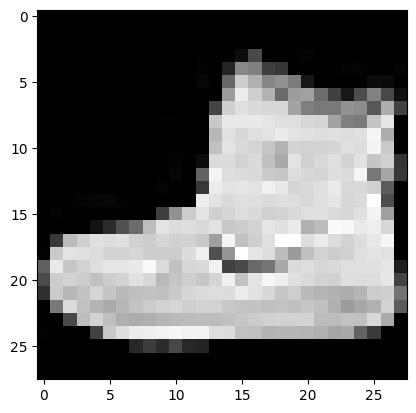

In [ ]:
print('Набор данных: ' + str(type(training_data)))
print('Длина: ' + str(len(training_data)))
print('Состоит из: ' + str(type(training_data[0])) +
      ', включающих в себя \n' + str(type(training_data[0][0])) + ' (изображение) ' +
      '\n и ' + str(type(training_data[0][1])) + ' (номер класса изображения)')
print('Размерность изображения: ' + str(training_data[0][0].shape))
print('Пример изображения:')
plt.imshow(training_data[0][0].squeeze(), cmap = 'gray')

### Использование DataLoader

Класс DataLoader используется для итерации по набору данных. DataLoader поддерживает такие операции, как разделение на подвыборки, перемешивание и параллельную загрузку данных. В этой работе DataLoader используется для разделения набора данных на подвыборки размера 64.

In [ ]:
batch_size = 16

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Размерность X [N, C, H, W]: {X.shape}")
    print(f"Размерность y: {y.shape}, тип: {y.dtype}")
    break

Размерность X [N, C, H, W]: torch.Size([16, 1, 28, 28])
Размерность y: torch.Size([16]), тип: torch.int64


### Создание модели

PyTorch может использовать видеокарты с поддержкой CUDA, доступность которых проверяется через функцию torch.cuda.is_available().

Модели в PyTorch представлены классами, которые наследуют базовый класс nn.Module.
<br>Каждая можель должна иметь функцию forward, определяющую расчёты, производящиеся при использовании модели.
<br>Используемые при расчётах слои создаются в конструкторе \_\_init__.
<br>Для удобства расчётов несколько стоящих подряд слоёв могут быть объединены в одну переменную с помощью nn.Sequential.

In [ ]:
# Использование устройство CUDA, если оно доступно
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

# Создание модели
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # Перед созданием слоёв выполняется вызов конструктора родительского класса
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Используется устройство: cpu
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Обучение модели

При обучении модели используется функция потерь nn.CrossEntropyLoss и метод оптимизации torch.optim.SGD.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

При обучении модель определяет классы изображений в тренировочном наборе данных (разделённом на подвыборки), после чего выполняет обратное распространение ошибки для корректировки параметров модели.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Перевод модели в режим обучения
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # Данные и модель должны находиться на одном устройстве

        # Расчёт потерь
        pred = model(X)
        loss = loss_fn(pred, y)

        # Обратное распространение ошибки
        optimizer.zero_grad() # Обнуление ранее рассчитанных градиентов
        loss.backward() # Расчёт новых градиентов
        optimizer.step() # Изменение весов (шаг обучения)

        if batch % 100 == 0: # Вывод информации каждые 100 итераций
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Также может быть определена функция тестирования для проверки качества обучения.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Перевод модели в режим тестирования
    test_loss, correct = 0, 0
    with torch.no_grad(): # Отключение расчёта градиентов для ускорения работы
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.291838  [    0/60000]
loss: 2.277162  [ 1600/60000]
loss: 2.283946  [ 3200/60000]
loss: 2.261334  [ 4800/60000]
loss: 2.233647  [ 6400/60000]
loss: 2.213686  [ 8000/60000]
loss: 2.210100  [ 9600/60000]
loss: 2.153640  [11200/60000]
loss: 2.196994  [12800/60000]
loss: 2.135398  [14400/60000]
loss: 2.136382  [16000/60000]
loss: 2.113517  [17600/60000]
loss: 2.097002  [19200/60000]
loss: 2.076400  [20800/60000]
loss: 2.069687  [22400/60000]
loss: 2.017707  [24000/60000]
loss: 1.982826  [25600/60000]
loss: 2.043973  [27200/60000]
loss: 1.937813  [28800/60000]
loss: 1.906235  [30400/60000]
loss: 1.805796  [32000/60000]
loss: 1.765758  [33600/60000]
loss: 1.646275  [35200/60000]
loss: 1.794698  [36800/60000]
loss: 1.832621  [38400/60000]
loss: 1.633617  [40000/60000]
loss: 1.561120  [41600/60000]
loss: 1.666707  [43200/60000]
loss: 1.377500  [44800/60000]
loss: 1.509094  [46400/60000]
loss: 1.540887  [48000/60000]
loss: 1.341809  [49600/60000]


### Сохранение и загрузка модели

Параметры модели могут быть сохранены в файл с помощью функции torch.save.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Загрузка модели включает в себя создание новой модели с той же структурой и загрузку сохранённых параметров.

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Загруженная модель может использоваться для определения классов изображений.

Predicted: "Pullover", Actual: "Pullover"
torch.Size([1, 28, 28])


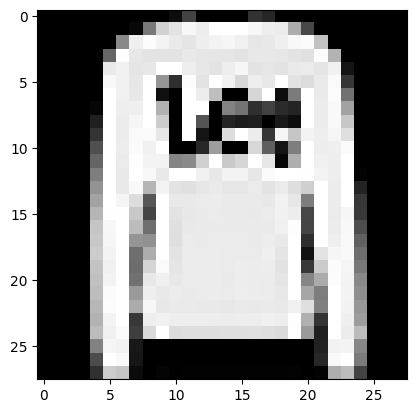

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    plt.imshow(x.squeeze(), cmap = 'gray')
print(test_data[0][0].shape)

### Задание

Попытайтесь улучшить качество распознавания, изменив функцию потерь, оптимизации, время обучения или структуру модели.
<br>Загрузите фотографию предмета одежды, приведите её к необходимому размеру и используйте обученную нейронную сеть для определения класса.

Было: batch: 64, epoches: 5, accuracy: 64%

Стало: batch: 16, epoches: 20, accuracy: 84%

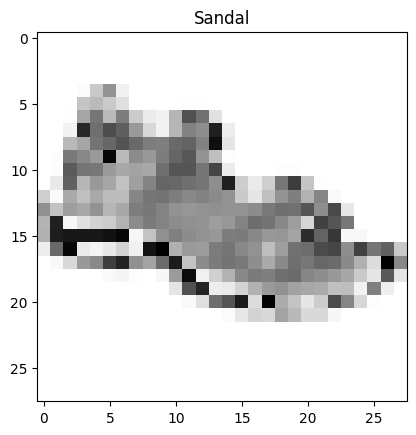

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt



# Загрузка изображения
image = Image.open('sss.jpeg')

# Преобразование изображения в формат, который может быть передан модели
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
image = transform(image).unsqueeze(0)

# Предсказание класса
with torch.no_grad():
    pred = model(image)
    predicted_class = pred.argmax(1).item()

# Вывод предсказанного класса и изображения
plt.imshow(transforms.ToPILImage()(image.squeeze()), cmap='gray')
plt.title(classes[predicted_class])
plt.show()